In [1]:
from scipy import stats
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import networkx.algorithms.community
from networkx.algorithms import community
import powerlaw
from cdlib import viz
from matplotlib.cm import ScalarMappable

# Importing real and random networks

In [2]:
def read_net_w(filename):
    g = nx.Graph()
    with open(filename) as f:
        f.readline()
        for l in f:
            l = l.split(",")
            g.add_node(l[0], bipartite = 0)
            g.add_node(l[1], bipartite = 1)
            g.add_edge(l[0], l[1], weight=int(l[2]))
            
    return g

g = read_net_w(f'Data/weighted_net_amsterdam.csv')

In [3]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 11266
Number of edges: 11265
Average degree:   1.9998


In [4]:
# an estimate for the Probability for edge creation
p = ((1.9998/11110) + (1.9998/156))/2

In [5]:
top_nodes = {n for n, d in g.nodes(data=True) if d["bipartite"] == 0}
bottom_nodes = set(g) - top_nodes #to obtain 2 set of nodes. 
                                  #This is usefull because a lot of bipartite functions need a set of nodes
print(len(top_nodes))
print(len(bottom_nodes))

11110
156


In [6]:
rand_g = bipartite.random_graph(len(top_nodes),len(bottom_nodes), p = p)

In [7]:
print(nx.info(rand_g))

Name: fast_gnp_random_graph(11110,156,0.006499615384615384)
Type: Graph
Number of nodes: 11266
Number of edges: 11171
Average degree:   1.9831


In [9]:
bipartite.is_bipartite(rand_g)

True

In [8]:
sequence_0 = [i[1] for i in g.degree() if i[0] in top_nodes]
sequence_1 = [i[1] for i in g.degree() if i[0] in bottom_nodes]

In [14]:
bcm_g = bipartite.configuration_model(sequence_0,sequence_1, create_using = nx.Graph())

In [21]:
print(nx.info(bcm_g))

Name: bipartite_configuration_model
Type: Graph
Number of nodes: 11266
Number of edges: 11256
Average degree:   1.9982


In [15]:
p0 = len(bottom_nodes)/len(top_nodes)
p1 = 1-p0

In [16]:
print(p0,p1)

0.014041404140414042 0.985958595859586


In [17]:
bsf = bipartite.preferential_attachment_graph(sequence_0,p0,create_using=nx.Graph())

In [18]:
bsf1 = bipartite.preferential_attachment_graph(sequence_1,p1,create_using=nx.Graph())

In [19]:
print(nx.info(bsf))

Name: bipartite_preferential_attachment_model
Type: Graph
Number of nodes: 11263
Number of edges: 11126
Average degree:   1.9757


In [20]:
print(nx.info(bsf1))

Name: bipartite_preferential_attachment_model
Type: Graph
Number of nodes: 11248
Number of edges: 11256
Average degree:   2.0014


# Comparison of path lengh

we campare path lenght on giant connected component

In [39]:
gc = g.subgraph(sorted(nx.connected_components(g), key=len, reverse=True)[0])
gc_rand_g = rand_g.subgraph(sorted(nx.connected_components(rand_g), key=len, reverse=True)[0])
gc_bcm_g = bcm_g.subgraph(sorted(nx.connected_components(bcm_g), key=len, reverse=True)[0])
gc_bsf1 = bsf1.subgraph(sorted(nx.connected_components(bsf1), key=len, reverse=True)[0])

In [40]:
print(nx.average_shortest_path_length(gc))

10.622011177691999


In [41]:
print(nx.average_shortest_path_length(gc_rand_g))

4.739765194562542


In [42]:
print(nx.average_shortest_path_length(gc_bcm_g))

5.182798490856276


In [43]:
print(nx.average_shortest_path_length(gc_bsf1))

6.266370374589076


# Comparison of Degree Distributions

In [23]:
real_observed_degree = [i[1] for i in g.degree()]
rand_observed_degree = [i[1] for i in rand_g.degree()]
bconf_observed_degree = [i[1] for i in bcm_g.degree()]
bsf_observed_degree = [i[1] for i in bsf.degree()]
bsf1_observed_degree = [i[1] for i in bsf1.degree()]

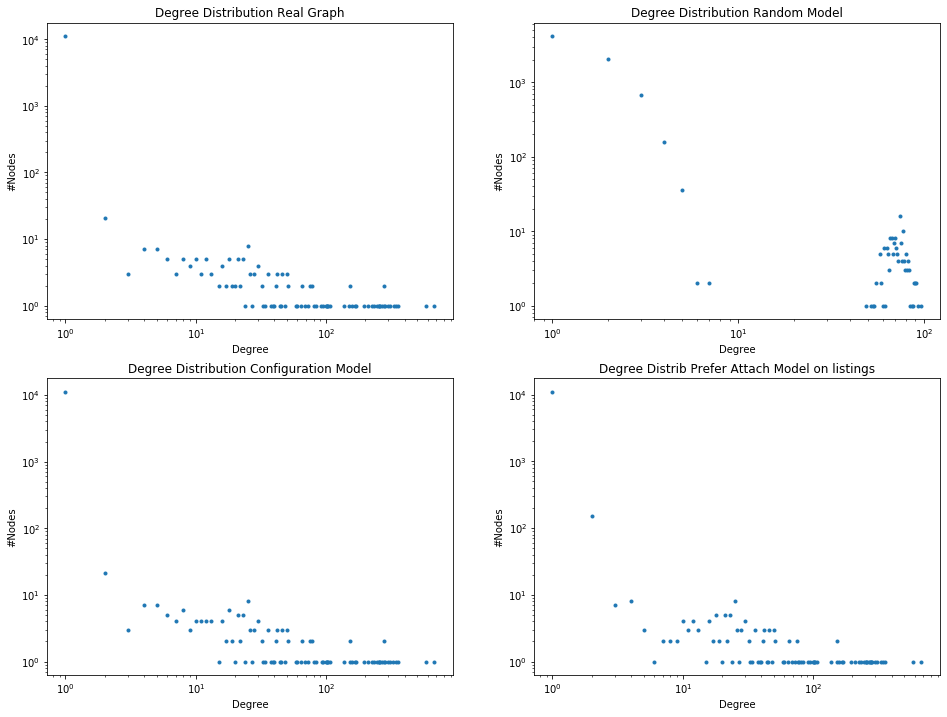

In [24]:
hist_real = nx.degree_histogram(g)
hist_rand = nx.degree_histogram(rand_g)
hist_bconf = nx.degree_histogram(bcm_g)
hist_bsf = nx.degree_histogram(bsf)
hist_bsf1 = nx.degree_histogram(bsf1)

fig = plt.figure(figsize=(16,12) )

plt.subplot(2,2,1)
plt.plot(range(0, len(hist_real)), hist_real, ".")
plt.title("Degree Distribution Real Graph")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()


plt.subplot(2,2,2)
plt.plot(range(0, len(hist_rand)), hist_rand, ".")
plt.title("Degree Distribution Random Model")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()



plt.subplot(2,2,3)
plt.plot(range(0, len(hist_bconf)), hist_bconf, ".")
plt.title("Degree Distribution Configuration Model")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()

plt.subplot(2,2,4)
plt.plot(range(0, len(hist_bsf1)), hist_bsf1, ".")
plt.title("Degree Distrib Prefer Attach Model on listings")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()



plt.show()

###### Comparison between real and artificial network through kolmogorov test

If the KS statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same

In [25]:
stats.ks_2samp(np.array(real_observed_degree),np.array(rand_observed_degree))

Ks_2sampResult(statistic=0.3561157464938754, pvalue=0.0)

In [26]:
stats.ks_2samp(np.array(real_observed_degree),np.array(bconf_observed_degree))

Ks_2sampResult(statistic=0.00017752529735481914, pvalue=1.0)

In [27]:
stats.ks_2samp(np.array(real_observed_degree),np.array(bsf_observed_degree))

Ks_2sampResult(statistic=0.011272028886863406, pvalue=0.47149743896090857)

In [28]:
stats.ks_2samp(np.array(real_observed_degree),np.array(bsf1_observed_degree))

Ks_2sampResult(statistic=0.010429263997288829, pvalue=0.5729622925552981)

# Compare Clustering coefficient,nr of conn comp and density

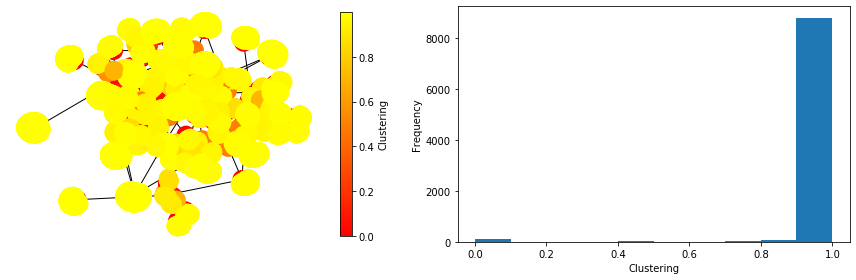

In [29]:
from matplotlib.cm import ScalarMappable
lcc = bipartite.clustering(gc)

cmap = plt.get_cmap('autumn')
norm = plt.Normalize(0, max(lcc.values()))
node_colors = [cmap(norm(lcc[node])) for node in gc.nodes]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
nx.draw_spring(gc, node_color=node_colors, with_labels=False, ax=ax1,linewidths= 2.0)
fig.colorbar(ScalarMappable(cmap=cmap, norm=norm), label='Clustering', shrink=0.95, ax=ax1)

ax2.hist(lcc.values(), bins=10)
ax2.set_xlabel('Clustering')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [30]:
print(nx.info(g))
print("Density : {}".format(bipartite.density(g,top_nodes)))
print("Clustering Coefficient : {}".format(bipartite.average_clustering(g)))
print("Number of Connected Components : {}".format(nx.number_connected_components(g)))

Name: 
Type: Graph
Number of nodes: 11266
Number of edges: 11265
Average degree:   1.9998
Density : 0.0064996884303814995
Clustering Coefficient : 0.9706144371680913
Number of Connected Components : 9


In [31]:
top_nodes_rand = {n for n, d in rand_g.nodes(data=True) if d["bipartite"] == 0}
bottom_nodes_rand = set(rand_g) - top_nodes_rand #to obtain 2 set of nodes. 
                                  #This is usefull because a lot of bipartite functions need a set of nodes
print(len(top_nodes_rand))
print(len(bottom_nodes_rand))

11110
156


In [32]:
print(nx.info(rand_g))
print("Density : {}".format(bipartite.density(rand_g,top_nodes_rand)))
print("Clustering Coefficient : {}".format(bipartite.average_clustering(rand_g)))
print("Number of Connected Components : {}".format(nx.number_connected_components(rand_g)))

Name: fast_gnp_random_graph(11110,156,0.006499615384615384)
Type: Graph
Number of nodes: 11266
Number of edges: 11171
Average degree:   1.9831
Density : 0.006445452237531446
Clustering Coefficient : 0.3218068059882518
Number of Connected Components : 4013


In [33]:
top_nodes_bcm = {n for n, d in bcm_g.nodes(data=True) if d["bipartite"] == 0}
bottom_nodes_bcm = set(bcm_g) - top_nodes_bcm #to obtain 2 set of nodes. 
                                  #This is usefull because a lot of bipartite functions need a set of nodes
print(len(top_nodes_bcm))
print(len(bottom_nodes_bcm))

11110
156


In [34]:
print(nx.info(bcm_g))
print("Density : {}".format(bipartite.density(bcm_g,top_nodes_bcm)))
print("Clustering Coefficient : {}".format(bipartite.average_clustering(bcm_g)))
print("Number of Connected Components : {}".format(nx.number_connected_components(bcm_g)))

Name: bipartite_configuration_model
Type: Graph
Number of nodes: 11266
Number of edges: 11256
Average degree:   1.9982
Density : 0.006494495603406494
Clustering Coefficient : 0.9707952214788624
Number of Connected Components : 80


In [35]:
top_nodes_bsf = {n for n, d in bsf.nodes(data=True) if d["bipartite"] == 0}
bottom_nodes_bsf = set(bsf) - top_nodes_bsf #to obtain 2 set of nodes. 
                                  #This is usefull because a lot of bipartite functions need a set of nodes
print(len(top_nodes_bsf))
print(len(bottom_nodes_bsf))

11110
153


In [36]:
print(nx.info(bsf))
print("Density : {}".format(bipartite.density(bsf,top_nodes_bsf)))
print("Clustering Coefficient : {}".format(bipartite.average_clustering(bsf)))
print("Number of Connected Components : {}".format(nx.number_connected_components(bsf)))

Name: bipartite_preferential_attachment_model
Type: Graph
Number of nodes: 11263
Number of edges: 11126
Average degree:   1.9757
Density : 0.006545360418394781
Clustering Coefficient : 0.9771047609670076
Number of Connected Components : 141


In [37]:
top_nodes_bsf1 = {n for n, d in bsf1.nodes(data=True) if d["bipartite"] == 0}
bottom_nodes_bsf1 = set(bsf1) - top_nodes_bsf1 #to obtain 2 set of nodes. 
                                  #This is usefull because a lot of bipartite functions need a set of nodes
print(len(top_nodes_bsf1))
print(len(bottom_nodes_bsf1))

156
11092


In [38]:
print(nx.info(bsf1))
print("Density : {}".format(bipartite.density(bsf1,top_nodes_bsf1)))
print("Clustering Coefficient : {}".format(bipartite.average_clustering(bsf1)))
print("Number of Connected Components : {}".format(nx.number_connected_components(bsf1)))

Name: bipartite_preferential_attachment_model
Type: Graph
Number of nodes: 11248
Number of edges: 11256
Average degree:   2.0014
Density : 0.006505034813725762
Clustering Coefficient : 0.964782898993546
Number of Connected Components : 82
